<a href="https://colab.research.google.com/github/sudotouchwoman/math-misc/blob/main/notebooks/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Word2Vec implementation**

In [ ]:
import torch
import torch.optim as optim
import torch.functional as F
import torch.nn as nn
import torch.utils.data as data

import numpy as np
import pandas as pd
import plotly.express as px

import re
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def reset_seeds(seed=42):
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
corpus = [
          'he is a king',
          'she is a queen',
          'he is a man',
          'she is a woman',
          'warsaw is poland capital',
          'berlin is germany capital',
          'moscow is russia capital',
          'paris is france capital',
          'he is an actor',
          'she is an actress',
          'he is a boy',
          'she is a girl',
          'the rewards of all your hard work in the garden are easy to see',
          'it is hard work to keep my room in proper order',
          'the hard work began to tell on him',
]

In [ ]:
# import nltk

# nltk.download('gutenberg')
# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# from nltk.corpus import (
#     gutenberg as gt,
#     stopwords as sw,
# )

# from nltk import punkt
# from nltk.tokenize import RegexpTokenizer

# corpus = gt.sents('melville-moby_dick.txt')
# stops = set(sw.words('english'))

# corpus

[['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', '1851', ']'], ['ETYMOLOGY', '.'], ...]

In [ ]:
# tokenized_corpus = corpus
# lowercased = [[word.lower() for word in sentence if word.isalpha()] for sentence in tokenized_corpus]

In [ ]:
class TokenizedCorpus:

  def __init__(self, text_corpus, filter=True):
    self.tokens = [sequence.split() for sequence in corpus]

  def __getitem__(self, index):
    return self.tokens[index]

In [ ]:
tokenized_corpus = TokenizedCorpus(corpus)

In [ ]:
for seq in tokenized_corpus[:5]:
  print(seq)

['he', 'is', 'a', 'king']
['she', 'is', 'a', 'queen']
['he', 'is', 'a', 'man']
['she', 'is', 'a', 'woman']
['warsaw', 'is', 'poland', 'capital']


In [ ]:
class LUT:

  def __init__(self, tokenized_corpus):
    self._tokenized_corpus = tokenized_corpus
    self.vocabulary = {token for seq in tokenized_corpus for token in seq}
    self.vocabulary = list(self.vocabulary)
    self.idx_pairs = None
    self.window_size = 0
    self._make_LUT()

  def _make_LUT(self):
    self.word2idx = {w: idx for idx, w in enumerate(self.vocabulary)}
    self.idx2word = {idx: w for idx, w in enumerate(self.vocabulary)}

  def idx_to_word(self, index):
    return self.idx2word[index]

  def word_to_idx(self, word):
    return self.word2idx[word]

  def __repr__(self):
    return '\n'.join((f'{idx} <-> {word}' for idx, word in self.idx2word.items()))

  def create_idx_pairs(self, window_size=2):
    if self.idx_pairs is not None\
    and self.window_size == window_size: return self.idx_pairs

    idx_pairs = []
    for seq in self._tokenized_corpus:
      indices = [self.word2idx[word] for word in seq]
      for center_pos, center_idx in enumerate(indices):
        for offset in range(-window_size, window_size + 1):
          context_pos = center_pos + offset
          if not 0 <= context_pos < len(indices): continue
          if context_pos == center_pos: continue
          context_idx = indices[context_pos]
          idx_pairs += [(center_idx, context_idx)]
    self.idx_pairs = np.asarray(idx_pairs)
    self.window_size = window_size

    return self.idx_pairs

In [ ]:
lut = LUT(tokenized_corpus)

print(lut.word_to_idx('king'))
print(lut.word_to_idx('she'))
print(lut.idx_to_word(1))
print(lut.idx_to_word(5))

7
15
paris
proper


In [ ]:
lut

0 <-> my
1 <-> paris
2 <-> capital
3 <-> russia
4 <-> hard
5 <-> proper
6 <-> it
7 <-> king
8 <-> girl
9 <-> began
10 <-> to
11 <-> man
12 <-> an
13 <-> in
14 <-> poland
15 <-> she
16 <-> your
17 <-> of
18 <-> a
19 <-> france
20 <-> boy
21 <-> actress
22 <-> him
23 <-> warsaw
24 <-> work
25 <-> room
26 <-> are
27 <-> actor
28 <-> tell
29 <-> queen
30 <-> garden
31 <-> the
32 <-> he
33 <-> berlin
34 <-> rewards
35 <-> moscow
36 <-> see
37 <-> germany
38 <-> easy
39 <-> woman
40 <-> keep
41 <-> order
42 <-> all
43 <-> is
44 <-> on

In [ ]:
idx_pairs = lut.create_idx_pairs(window_size=4)

In [ ]:
idx_pairs.shape

(348, 2)

In [ ]:
idx_pairs

In [ ]:
mapper = lambda pair: (lut.idx_to_word(pair[0]), lut.idx_to_word(pair[1]))

for bigram in map(mapper, idx_pairs):
  print(bigram)

In [ ]:
class Word2Vec(nn.Module):

  def __init__(self, lut: LUT, embedding_size: int):
    super(Word2Vec, self).__init__()

    self.lut = lut
    self.vocab_size = len(lut.vocabulary)
    self.embedding_size = embedding_size

    self.encoder = nn.Linear(self.vocab_size, embedding_size)
    self.decoder = nn.Linear(embedding_size, self.vocab_size)
    self.log_sm = nn.LogSoftmax(dim=0)

  def _get_OhE(self, index):
    x = torch.zeros(self.vocab_size).float()
    x[index] = 1.0
    return x

  def forward(self, word_idx):
    ohe = self._get_OhE(word_idx)
    embedding = self.encoder(ohe)
    decoder = self.decoder(embedding)
    return self.log_sm(decoder)

  def get_embedding(self, word_idx):
    ohe = self._get_OhE(word_idx)
    embedding = self.encoder(ohe)
    return embedding


class W2VDataset(data.Dataset):

  def __init__(self, index_pairs):
    self.pairs = index_pairs
    self.len = len(self.pairs)

  def __getitem__(self, index):
    x, y = self.pairs[index]
    x = torch.Tensor([x]).long().squeeze_()
    y = torch.Tensor([y]).long().squeeze_()
    return x, y

  def __len__(self):
    return self.len

In [ ]:
reset_seeds()

dataset = W2VDataset(idx_pairs)
dataloader = data.DataLoader(dataset, shuffle=True)

model = Word2Vec(lut, embedding_size=30)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=5e-3, momentum=.8, nesterov=True)

In [ ]:
reset_seeds()
epoch_cnt = 1000

losses = []

for epoch in tqdm(range(epoch_cnt)):
  epoch_loss = .0

  for given, context in dataloader:
    optimizer.zero_grad()

    y_hat = model(given)
    loss = criterion(y_hat.view(1, -1), context)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  losses += [epoch_loss / len(dataset)]

  # if epoch % 10 == 0:
  #   print(f'[{epoch + 1}/{epoch_cnt}] Loss: {losses[-1]}')

100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


In [ ]:
px.line(y=losses)

In [ ]:
model.eval()

selected_words = (
    'boy',
    'girl',
    'king',
    'queen',
    'actor',
    'actress',
    'he',
    'she',
    'paris',
    'moscow',
    'berlin',
    'france',
    'russia',
    'germany'
)

words = lut.vocabulary
embeddings = [model.get_embedding(lut.word_to_idx(word)).detach().numpy() for word in words]
selected_embeddings = [model.get_embedding(lut.word_to_idx(word)).detach().numpy() for word in selected_words]

embeddings = np.asarray(embeddings)
selected_embeddings = np.asarray(selected_embeddings)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [ ]:
def normalize(tabular_data):
  return (tabular_data - tabular_data.mean()) / tabular_data.std()

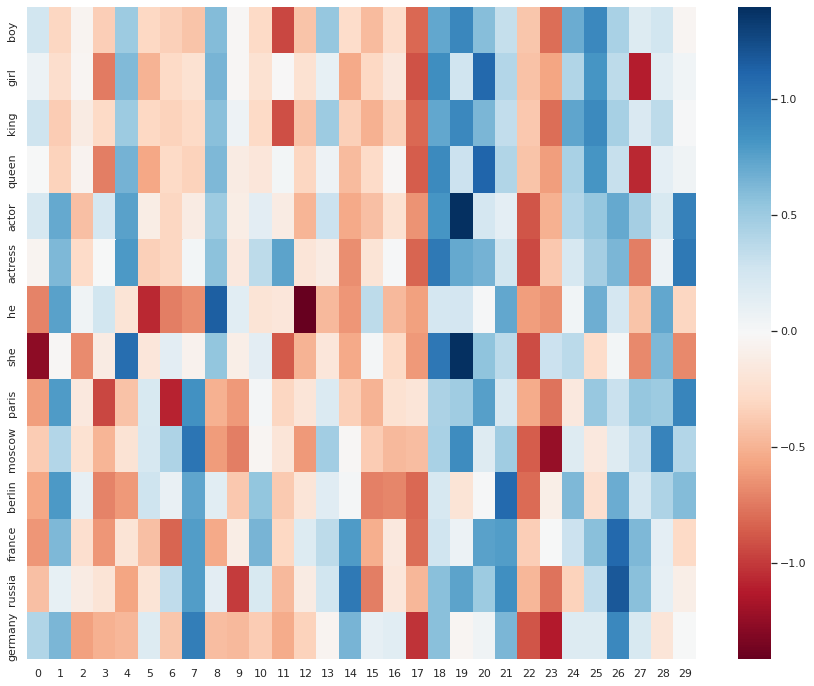

In [ ]:
fig = plt.figure(figsize=(15, 12))
sns.heatmap(selected_embeddings, yticklabels=selected_words, cmap='RdBu')
fig.show()

In [ ]:
from sklearn.decomposition import PCA

mapper = PCA(n_components=3, random_state=20)
pc = mapper.fit_transform(embeddings)

In [ ]:
points = pd.DataFrame(
    {
        'Component 1': pc[:, 0],
        'Component 2': pc[:, 1],
        'Component 3': pc[:, 2],
        'Word': words
    }
)

fig = px.scatter_3d(
    points,
    x='Component 1',
    y='Component 2',
    z='Component 3',
    text='Word',
    title='PCA over embeddings',
    width=900,
    height=800)

fig.show()